## Домашнее задание

Проведите аналогичный анализ с помощью DESeq2 и сравните его результаты с результатами edgeR и реализованной нами GLM (можете построить scatter plot для p-value, полученных разными методами).

В чем основные различия используемых моделей и тестов?

Для этого нужно будет:

1.   Импортировать еще раз из аутпута salmon наши каунты, но теперь выгрузить в DESeq2, а не в edgeR (https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html#DESeq2)
2.   Реализовать стандартный пайплайн DESeq2, сравнивая с тем, как это делается в edgeR (https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

## Решение

---
### Установка пакетов и импорт данных

На всякий случай обновим gdown для того, чтобы датасет c google disk скачался удачно

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Установим и подгрузим нужную версию rpy2

In [91]:
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Скачаем необходимые для R библиотеки

In [ ]:
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown --id 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!cp -r /content/usr/local/lib/R /usr/local/lib/
!rm -r usr

Установим недостающие библиотеки вручную

In [ ]:
%R .libPaths("usr/local/lib/R/site-library/")

!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidyr")'
!Rscript -e 'install.packages("stringr")'
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("MASS")'
!Rscript -e 'BiocManager::install("EnhancedVolcano")'
!Rscript -e 'BiocManager::install("DESeq2")'
!Rscript -e 'BiocManager::install("apeglm")'
!Rscript -e 'install.packages("repr")'

Подгрузим библиотеки в R

In [92]:
%%R

suppressPackageStartupMessages({
  library(edgeR)
  library(stringr)
  library(dplyr)
  library(tidyr)
  library(tximport)
  library(EnsDb.Mmusculus.v79)
  library(ggplot2)
  library(MASS)
  library(glue)
  library(EnhancedVolcano)
  library(DESeq2)
  library(apeglm)
  library(repr)
})

Скачаем датасет с экспрессиями

In [ ]:
!wget -r -np -R "index.html*" http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/
!mkdir data
!mkdir data/samples
!mv arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/samples/* data/samples
!rm -r arcuda.skoltech.ru

Скачаем датасет с референс транскриптомом мышей

In [ ]:
!wget -O data/mouse_mart.csv http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv

--2023-01-08 07:54:47--  http://arcuda.skoltech.ru/~d.bobrovsky/teaching/transcriptomics/mouse_mart.csv
Resolving arcuda.skoltech.ru (arcuda.skoltech.ru)... 195.133.216.197
Connecting to arcuda.skoltech.ru (arcuda.skoltech.ru)|195.133.216.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13518751 (13M)
Saving to: ‘data/mouse_mart.csv’

data/mouse_mart.csv 100%[===================>]  12.89M  4.07MB/s    in 3.2s    

2023-01-08 07:54:51 (4.07 MB/s) - ‘data/mouse_mart.csv’ saved [13518751/13518751]



---
## Подготовка данных к DESeq2

Загрузка аннотированного генома мыши и загрузка Ensebml Mouse Transcripts IDs (ENSMUST)

In [93]:
%%R

txdb <- EnsDb.Mmusculus.v79
tx2gene <- transcripts(txdb, return.type="DataFrame")

Преобразование Ensembl Mouse Transcripts IDs в Ensembl Mouse Genes IDs: ENSMUST $\rightarrow$ ENSMUSG



In [94]:
%%R

tx2gene <- tx2gene[c("tx_id","gene_id")]

In [95]:
%%R

head(tx2gene)

DataFrame with 6 rows and 2 columns
               tx_id            gene_id
         <character>        <character>
1 ENSMUST00000082387 ENSMUSG00000064336
2 ENSMUST00000179436 ENSMUSG00000095742
3 ENSMUST00000082388 ENSMUSG00000064337
4 ENSMUST00000177695 ENSMUSG00000094121
5 ENSMUST00000082389 ENSMUSG00000064338
6 ENSMUST00000082390 ENSMUSG00000064339


Создание вектора из путей файлов с экспрессиями генов

In [96]:
%%R

samples <- str_c(c(str_c("wt_water_",c(1,2,3,4)),
                   str_c("wt_bicarb_",c(1,2,3,4)),
                   str_c("ko_water_",c(1,2,3,4)),
                   str_c("ko_bicarb_",c(1,2,3,4))),".sf")

files <- str_c("data/samples/",samples)

Загрузка наших данных в tximport

In [97]:
%%R

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, ignoreTxVersion=T)
cts <- txi$counts

Загрузка .csv файла с референс геномом

In [98]:
%%R

mart <- read.csv("data/mouse_mart.csv")

Создание фильтра с протеин кодирующими генами

In [99]:
%%R

genetype <- mart$Gene.type[match(rownames(cts), mart$Gene.stable.ID)]
typefilter <- genetype == "protein_coding"
typefilter[is.na(typefilter)] <- FALSE

Фильтрация наших данных через фильтр

In [100]:
%%R

cts <- cts[typefilter,]
txi$counts <- txi$counts[typefilter, ]
txi$abundance <- txi$abundance[typefilter,]
txi$length <- txi$length[typefilter,]

---

## Анализ экспрессии с помощью DESeq2

Импортируем наш датасет в виде tximport object в DESeq c указанием тестируемых групп.

WT — Wild type (дикий тип мышей).  
KO — Nocaute Mouse (нокаутный тип мышей или лабораторный тип).  
Water — Water treatment (кормление мышей обычной водой).  
Bicarb — Bicarb treatment (кормление мышей водой с повышенной концентрацией бикарбонатов).


In [101]:
%%R

# WT = "Wild mouse type"
# KO = "Nocaute Mouse" 
# Water = Water treatment
# Bicarb = Bicarbonate treatment

condition <- c(rep("WT_Water", 4), 
               rep("WT_Bicarb", 4),
               rep("KO_Water", 4),
               rep("KO_Bicarb", 4))

sampleTable <- data.frame(condition = condition)

dds <- DESeqDataSetFromTximport(txi, sampleTable, design = ~condition)

In [102]:
%%R

design(dds)

~condition


In [103]:
%%R

dds$condition

 [1] WT_Water  WT_Water  WT_Water  WT_Water  WT_Bicarb WT_Bicarb WT_Bicarb
 [8] WT_Bicarb KO_Water  KO_Water  KO_Water  KO_Water  KO_Bicarb KO_Bicarb
[15] KO_Bicarb KO_Bicarb
Levels: KO_Bicarb KO_Water WT_Bicarb WT_Water


Проведем анализ дифференциальной экспрессии с помощью DESeq с использованием Likelihood ratio test (LRT).

In [ ]:
%%R

dds <- DESeq(dds, test="LRT", reduced = ~1)

# filtering minimum counts 
dds <- dds[rowSums(counts(dds, normalized = TRUE)) >= 100,]

In [116]:
%%R

dds

class: DESeqDataSet 
dim: 13674 16 
metadata(1): version
assays(6): counts avgTxLength ... H cooks
rownames(13674): ENSMUSG00000000001 ENSMUSG00000000028 ...
  ENSMUSG00000104346 ENSMUSG00000104445
rowData names(25): baseMean baseVar ... deviance maxCooks
colnames: NULL
colData names(1): condition


In [118]:
%%R

res <- results(dds)

In [119]:
%%R

head(res)

log2 fold change (MLE): condition WT Water vs KO Bicarb 
LRT p-value: '~ condition' vs '~ 1' 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000000001  786.2827       0.448049 0.0704631 62.008282 2.18816e-13
ENSMUSG00000000028   18.1981       0.209794 0.3414668  0.500689 9.18740e-01
ENSMUSG00000000056  706.8992      -0.231329 0.1205904 31.710033 6.02410e-07
ENSMUSG00000000058  287.4423       0.434304 0.1397790 10.599190 1.41029e-02
ENSMUSG00000000078  671.2699      -0.194872 0.0719638  8.137219 4.32593e-02
ENSMUSG00000000085  366.3524      -0.663415 0.1981054 42.801366 2.71196e-09
                          padj
                     <numeric>
ENSMUSG00000000001 6.20334e-12
ENSMUSG00000000028 9.59917e-01
ENSMUSG00000000056 6.54290e-06
ENSMUSG00000000058 4.52436e-02
ENSMUSG00000000078 1.12029e-01
ENSMUSG00000000085 4.45260e-08


In [120]:
%%R

summary(res)


out of 13674 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2475, 18%
LFC < 0 (down)     : 2526, 18%
outliers [1]       : 27, 0.2%
low counts [2]     : 266, 1.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Выгрузим из DESeqDataSet объекта результаты попарных сравнений:
* Нокаутные мыши на водной и бикарбонатной диете
* Дикие мыши на водной и бикарбонатной диете
* Нокаутные и дикие мыши на водной диете
* Нокаутные и дикие мыши на бикарбонатной диете

In [ ]:
%%R

res_KO_vs_Treat <- results(dds, contrast=c("condition", "KO_Water", "KO_Bicarb"), alpha=0.05)
res_WT_vs_Treat <- results(dds, contrast=c("condition", "WT_Water", "WT_Bicarb"), alpha=0.05)
res_Water_vs_KOWT <- results(dds, contrast=c("condition", "KO_Water", "WT_Water"), alpha=0.05)
res_Bicarb_vs_KOWT <- results(dds, contrast=c("condition", "KO_Bicarb", "WT_Bicarb"), alpha=0.05)

In [105]:
%%R

resultsNames(dds)

[1] "Intercept"                        "condition_KO_Water_vs_KO_Bicarb" 
[3] "condition_WT_Bicarb_vs_KO_Bicarb" "condition_WT_Water_vs_KO_Bicarb" 


In [109]:
%%R 

summary(res_Water_vs_KOWT)


out of 13674 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2199, 16%
LFC < 0 (down)     : 2068, 15%
outliers [1]       : 27, 0.2%
low counts [2]     : 266, 1.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [110]:
%%R 

summary(res_Bicarb_vs_KOWT)


out of 13674 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2205, 16%
LFC < 0 (down)     : 2061, 15%
outliers [1]       : 27, 0.2%
low counts [2]     : 266, 1.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
%%R

summary(res_WT_vs_Treat)


out of 13674 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2147, 16%
LFC < 0 (down)     : 2118, 15%
outliers [1]       : 27, 0.2%
low counts [2]     : 266, 1.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [ ]:
%%R

summary(res_KO_vs_Treat)


out of 13674 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2421, 18%
LFC < 0 (down)     : 1840, 13%
outliers [1]       : 27, 0.2%
low counts [2]     : 266, 1.9%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Создадим вектор с символьными обозначениями генов: ENSMUG id $\rightarrow$ Gene symbol



In [ ]:
%%R

require(org.Mm.eg.db)
Symbol <- mapIds(org.Mm.eg.db, keys=rownames(res_bicarb_vs_KOWT), keytype="ENSEMBL", column="SYMBOL")

Добавим в датасеты столбец с символьным обозначением Ensemble Mouse Genes Ids

In [ ]:
res_bicarb_vs_KOWT$gene <- Symbol
res_water_vs_KOWT$gene <- Symbol
res_WT_vs_treat$gene <- Symbol
res_KO_vs_treat <- Symbol

Построим volcano plot для группы "нокаутные и дикие мыши на бикарбонатной диете".

In [ ]:
%%R

library(repr)

options(repr.plot.width=50, repr.plot.height=50)

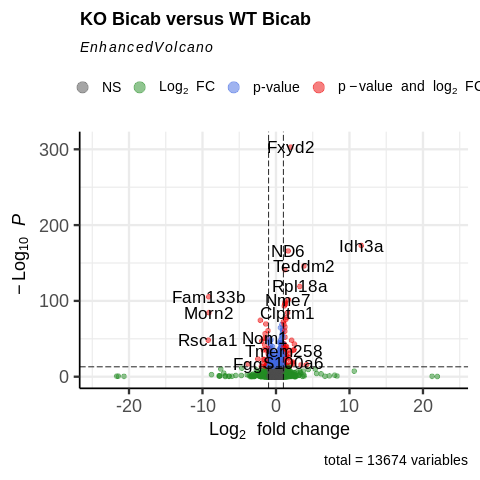

In [124]:
%%R

EnhancedVolcano(res_bicarb_vs_KOWT,
  lab = res_bicarb_vs_KOWT$gene,
  title = 'KO Bicab versus WT Bicab',
  x = 'log2FoldChange',
  pCutoff = 10e-14,
  y = 'pvalue',
  pointSize = 2.0,
  labSize = 6.0)



P.S. К сожалению, у меня не удалось настроить размер volcano plot, поэтому график получился не таким красивым, каким мог быть.

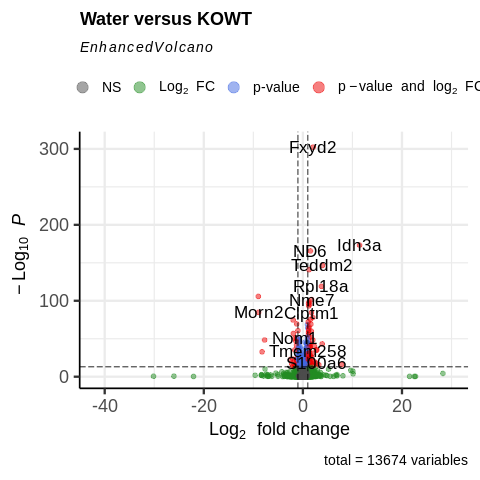

In [ ]:
%%R

EnhancedVolcano(res_water_vs_KOWT,
  lab = res_water_vs_KOWT$gene,
  title = 'Water versus KOWT',
  x = 'log2FoldChange',
  pCutoff = 10e-14,
  y = 'pvalue',
  pointSize = 2.0,
  labSize = 6.0)

DESeq2 отличается от edgeR на этапе нормализации каунтов. 

edgeR нормализует каунты следуюзим образом:
1. Определяет гены, которые меньше всего изменили свою экспрессию (обычно, это гены домашнего хозяйства, т.е. housekeeping genes) в разных образцах.
2. Вычисляет среднее значение изменения данных генов 
3. Домножает каждый из образцов на полученный нормировочный коэффициент.

DESeq же проводит нормализацию по следующей схеме:

1. Вычисляет среднегеометрическое экспрессии каунтов всех образцов каждого гена (pseudo-reference sample)
2. Разделяет каунты каждого образца на соответствующее среднегеометрическое (ratio of sampleA/ref и ratio of sampleB/ref)
3. Определяет медианы массива значений предыдущего этапа у каждого образца
4. Полученные медианы каждого из образцов и будут являться нормировочными коэффициентами, на которые необходимо разделить каунты каждого гена на соответствующий образцу коэффициент.